# Preambule

Run this code to import modules and define some functions that may result useful

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import MT19937, RandomState, SeedSequence
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Functions to simplify plotting

def hard_split(z_orig, threshold=0.0, eps=1e-5):
    ''' Turns a decision functions or score into hard labels
    '''
    z = z_orig.copy()
    z[z > threshold + eps] = 1
    z[z < threshold - eps] = -1
    return z


def getXYRange2D(X):
    ''' Return the limits for a 2d scatter plot of points
            X is of shape n x 2 where n is the number of points
            returns xmin, xmax, ymin, ymax
    '''
    return min(X[:, 0]), max(X[:, 0]), min(X[:, 1]), max(X[:, 1])

# Example with linear models for regression

1. Use `sklearn` [linear model](https://scikit-learn.org/stable/modules/linear_model.html) to estimate a linear model using least squares and the folowing data

<center>

| x | y   |
|---|-----|
| 1 | 1   |
| 9 | 9.5 |
| 9 | 2.5 |

</center>

2. Plot the data and the obtained linear function






(0.0, 10.0)

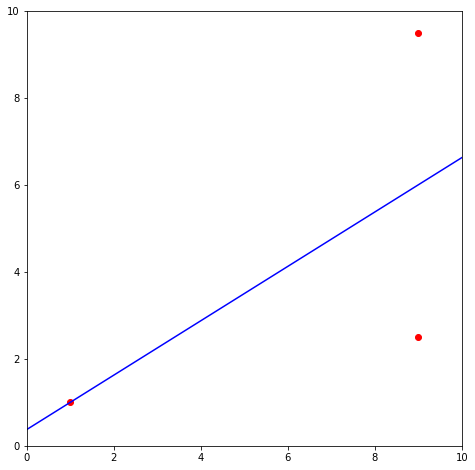

In [3]:
X = np.array([[1],
              [9],
              [9]
              ])
Y = np.array([1,
              9.5,
              2.5])

# Fit model
reg = LinearRegression()
reg.fit(X, Y)

# Plot
cmap = 'coolwarm'
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], Y, cmap=cmap, c='red')
x_r = np.linspace(0.0, 10, 50)

w, b = reg.coef_, reg.intercept_
y_r = b + w * x_r
ax.plot(x_r, y_r, c='blue')

ax.set_aspect('equal')
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)

Now let us try another interesting situation. On the last example we had two points with the same $x$ component and different $y$ component and the resulting linear function passed on the middle of the two $y$.

Now imagine we have many points clustered around one of the two original points. What happens to the resulting model?

3. Repeat the last example but instead of ony 3 points, add a few points around on the two points that had the same $x$ coordinate

(0.0, 10.0)

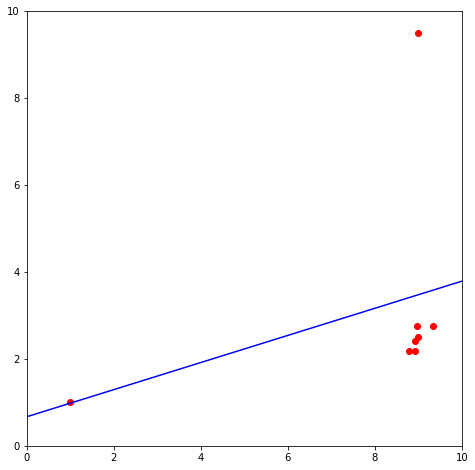

In [4]:
X = np.array([[1],
              [9],
              [9]
              ])
Y = np.array([1,
              9.5,
              2.5])

N = 5
others = np.random.multivariate_normal(np.c_[X[-1].ravel(), Y[-1]].ravel(),
                                       np.eye(2) * 0.1, size=N)

X = np.concatenate([X, others[:, 0].reshape(-1, 1)], axis=0)
Y = np.concatenate([Y, others[:, 1]], axis=0)

# Fit model
reg = LinearRegression()
reg.fit(X, Y)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], Y, cmap='cooldown', c='red')
x_r = np.linspace(0.0, 10, 50)

w, b = reg.coef_, reg.intercept_
y_r = b + w * x_r
ax.plot(x_r, y_r, c='blue')

ax.set_aspect('equal')
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)

Having seen the behaviour of the estimated linear model with the new points, what can you say about the linear model learned using least squares?


**BONUS**: We could state the least squares problem but minimizing a different function that measures the error between observations and predictions. What happens if instead of the squared error $(\hat{y} - y)^2$ we use the absolute error $| \hat{y} - y |$? 

# ESL Section 2.3 example

In this example we are going to try to classify some synthetic data using a linear model and a k-nearest neighbors model.

We want to:

- Get a first impression on the effect of the parameter $k$ in the resulting classifier looking at the decision function.
- Relate the effect of the parameter $k$ to the concepts of over and under fitting
- Evaluate the capacity of a simple linear model in the classification setting


## Generate data

Authors created data by first setting 10 points for each class following distributions $\mathcal{N}((1,0), \mathbb{I})$ and $\mathcal{N}((0,1), \mathbb{I})$. Then each other point is generated as follows:

For each class, do 100 times the following:

- Choose uniformly at random one of the 10 base points $m_k$ of the given class
- Sample a point from the distribution $\mathcal{N}(m_k, \mathbb{I}/5)$



Generate the data and plot it

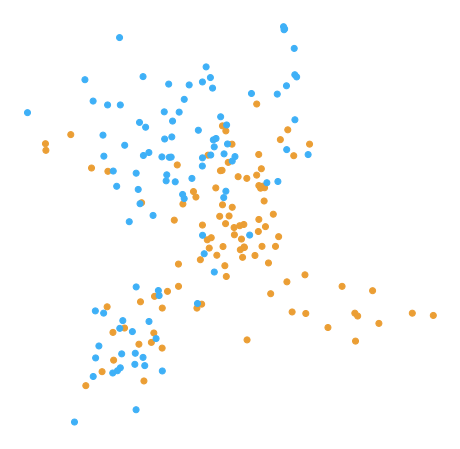

In [5]:
def generate_example_data_2(N=100, seed=111):
    ''' This can be hard to read, so I will make a simpler version afterwards'''
    rs = RandomState(MT19937(SeedSequence(seed)))

    # base points
    m0 = rs.multivariate_normal(np.array([1, 0]), cov=np.eye(2), size=10)
    m1 = rs.multivariate_normal(np.array([0, 1]), cov=np.eye(2), size=10)

    # actual points
    p0 = rs.multivariate_normal(np.array([0, 0]), cov=np.eye(2) / 5.0, size=N)
    p1 = rs.multivariate_normal(np.array([0, 0]), cov=np.eye(2) / 5.0, size=N)

    s = rs.randint(0, 10, size=N)
    p0 = p0 + m0[s]
    s = rs.randint(0, 10, size=N)
    p1 = p1 + m1[s]

    X = np.concatenate([p0, p1], axis=0)
    Y = np.array([0.0] * N + [1.0] * N)
    return X, Y


def generate_example_data(N=100, seed=111):
    rs = RandomState(MT19937(SeedSequence(seed)))

    # base points
    m0 = rs.multivariate_normal(np.array([1, 0]), cov=np.eye(2), size=10)
    m1 = rs.multivariate_normal(np.array([0, 1]), cov=np.eye(2), size=10)

    I5 = np.eye(2) / 5.0
    Y = []
    # Class 0
    X_0 = np.zeros((N, 2))
    for i in range(N):
        mk = m0[rs.choice(10)]
        X_0[i, :] = rs.multivariate_normal(mk, cov=I5, size=1)
        Y.append(0)

    # Class 1
    X_1 = np.zeros((N, 2))
    for i in range(N):
        mk = m1[rs.choice(10)]
        X_1[i, :] = rs.multivariate_normal(mk, cov=I5, size=1)
        Y.append(1)

    X = np.concatenate([X_0, X_1], axis=0)
    Y = np.array(Y)
    return X, Y


X, Y = generate_example_data(100)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], c=np.where(Y == 1, '#3eb0f7', '#eb9e34'), marker='o')

ax.axis('off');

## Linear model using least squares

Learn a linear model trying to fit the labels as if they were continous. To turn the regression model into a classifier we will use the following decision rule to predict a class $\hat{y} \in \lbrace 0, 1 \rbrace$:

$$\hat{y} = 1  \text{ if } f(x) \gt 0.5 \text{, } 0 \text{ otherwise.}$$


Plot the data and the resulting classifier. 

You can have a look at the functions [contour](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html) and [contourf](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contourf.html) of `matplotlib` to get a nice plot.

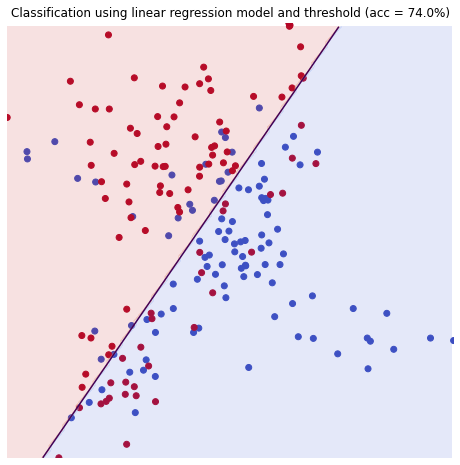

In [6]:
linear_clf = LinearRegression()
linear_clf.fit(X, Y)

y_hat = np.where(linear_clf.predict(X) > 0.5, 1.0, 0.0)
acc_linear = accuracy_score(Y, y_hat)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

cmap = 'coolwarm'

ax.scatter(X[:, 0], X[:, 1], cmap=cmap, c=Y)

xm, xM, ym, yM = getXYRange2D(X)
x_range, y_range = np.arange(xm, xM, 0.05), np.arange(ym, yM, 0.05)
xx, yy = np.meshgrid(x_range, y_range)
xxyy = np.c_[xx.ravel(), yy.ravel()]
z = linear_clf.predict(xxyy).reshape(xx.shape)

z_hard = hard_split(z, threshold=0.5)

ax.contourf(xx, yy, z_hard, alpha=0.15, cmap=cmap)
ax.contour(xx, yy, z, levels=[0.5])

ax.set_xlim(xm, xM)
ax.set_ylim(ym, yM)
ax.set_title(f'Classification using linear regression model and threshold (acc = {acc_linear * 100}%)')
ax.axis('off');

## Nearest neighbors

Create a nearest neighbors classifier and plot the decision regions

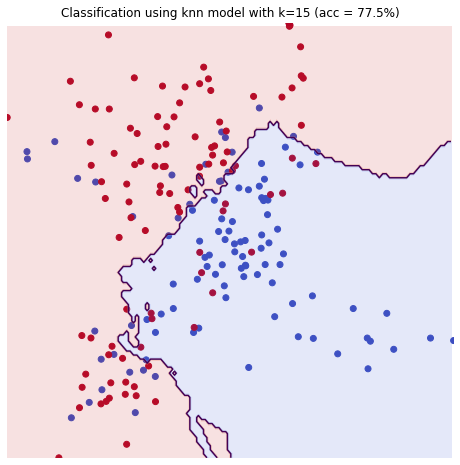

In [7]:
k = 15
knn_clf = KNeighborsClassifier(n_neighbors=k)
knn_clf.fit(X, Y)

y_hat = np.where(knn_clf.predict(X) > 0.5, 1.0, 0.0)
acc = accuracy_score(Y, y_hat)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

cmap = 'coolwarm'

ax.scatter(X[:, 0], X[:, 1], cmap=cmap, c=Y)

xm, xM, ym, yM = getXYRange2D(X)
x_range, y_range = np.arange(xm, xM, 0.05), np.arange(ym, yM, 0.05)
xx, yy = np.meshgrid(x_range, y_range)
xxyy = np.c_[xx.ravel(), yy.ravel()]
z = knn_clf.predict(xxyy).reshape(xx.shape)

z_hard = hard_split(z, threshold=0.5)

ax.contourf(xx, yy, z_hard, alpha=0.15, cmap=cmap)
ax.contour(xx, yy, z, levels=[0.5])

ax.set_xlim(xm, xM)
ax.set_ylim(ym, yM)
ax.set_title(f'Classification using knn model with k={k} (acc = {acc * 100}%)')
ax.axis('off');

Now that we can train and evaluate a nearest neighbors model we are going to see how the train and test error behaves with respect to $k$

1. Plot the accuracy on the training set of the model with respect to the parameter $k$
2. Plot now the accuracy on a test set (new data produced using the same data generation process)
3. Plot also the accuracy of the linear classifier to compare it with the KNN

Text(0.5, 1.0, 'Evolution of train/test accuracy for knn w.r.t k')

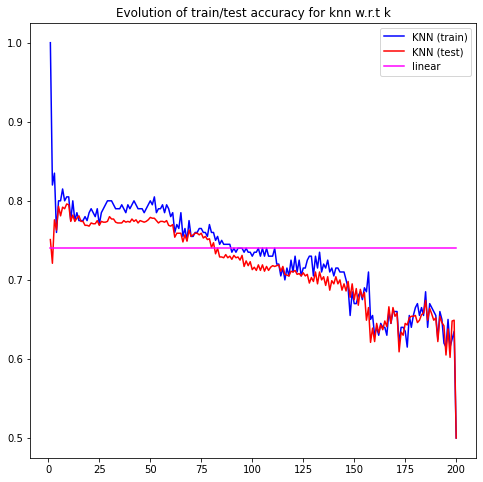

In [8]:
x_r = list(range(1, 201))
X_test, Y_test = generate_example_data(N=500)
acc_train, acc_test = [], []
for k in x_r:
    knn_clf = KNeighborsClassifier(n_neighbors=k)
    knn_clf.fit(X, Y)

    y_hat = knn_clf.predict(X)
    acc_train.append(accuracy_score(Y, y_hat))
    y_hat = knn_clf.predict(X_test)
    acc_test.append(accuracy_score(Y_test, y_hat))

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(x_r, acc_train, c='blue', label='KNN (train)')
ax.plot(x_r, acc_test, c='red', label='KNN (test)')
ax.plot(x_r, [acc_linear] * len(x_r), label='linear', c='magenta')
ax.legend()
ax.set_title("Evolution of train/test accuracy for knn w.r.t k")

What can you say about the performance of the linear classifier and the KNN classifier for this particular data distribution?




Now let us change the data generation process and repeat the last steps with simply two classes produced by two multivariate normals $\mathcal{N}((1,0), \mathbb{I}/5)$ and $\mathcal{N}((0,1), \mathbb{I}/5)$. This means that instead of doing the two steps (10 centers, then points sampled around centers) we just consider each class is sampled from a multivariate normal



Train the linear classifier and the KNN, and repeat the plot from the previous step

Text(0.5, 1.0, 'Evolution of train/test accuracy for knn w.r.t k')

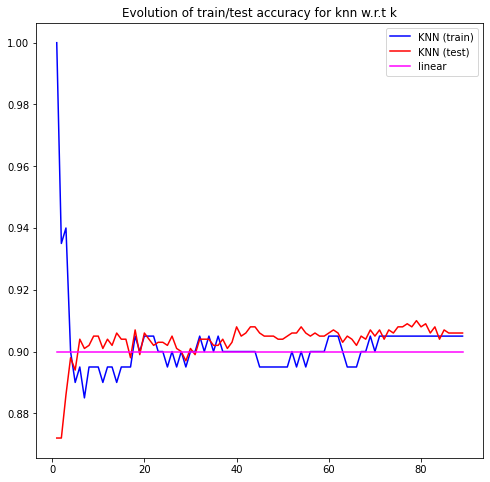

In [9]:
def generate_blobs(N=100, seed=111):
    rs = RandomState(MT19937(SeedSequence(seed)))
    # base points
    p0 = rs.multivariate_normal(np.array([1, 0]), cov=np.eye(2) * 0.3, size=N)
    p1 = rs.multivariate_normal(np.array([0, 1]), cov=np.eye(2) * 0.3, size=N)

    X = np.concatenate([p0, p1], axis=0)
    Y = np.array([0.0] * N + [1.0] * N)
    return X, Y


# Data
X, Y = generate_blobs(100)

# Linear classifier
linear_clf = LinearRegression()
linear_clf.fit(X, Y)

y_hat = np.where(linear_clf.predict(X) > 0.5, 1.0, 0.0)
acc_linear = accuracy_score(Y, y_hat)

# KNN
x_r = list(range(1, 90))
X_test, Y_test = generate_blobs(N=500)
acc_train, acc_test = [], []
for k in x_r:
    knn_clf = KNeighborsClassifier(n_neighbors=k)
    knn_clf.fit(X, Y)
    y_hat = knn_clf.predict(X)
    acc_train.append(accuracy_score(Y, y_hat))
    y_hat = knn_clf.predict(X_test)
    acc_test.append(accuracy_score(Y_test, y_hat))

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(x_r, acc_train, c='blue', label='KNN (train)')
ax.plot(x_r, acc_test, c='red', label='KNN (test)')
ax.plot(x_r, [acc_linear] * len(x_r), label='linear', c='magenta')
ax.legend()
ax.set_title("Evolution of train/test accuracy for knn w.r.t k")

In [10]:
k = 3
knn_clf = KNeighborsClassifier(n_neighbors=k)
knn_clf.fit(X, Y)

y_hat = np.where(knn_clf.predict(X) > 0.5, 1.0, 0.0)
acc = sklearn.metrics.accuracy_score(Y, y_hat)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

cmap = 'coolwarm'

ax.scatter(X[:, 0], X[:, 1], cmap=cmap, c=Y)

xm, xM, ym, yM = getXYRange2D(X)
x_range, y_range = np.arange(xm, xM, 0.05), np.arange(ym, yM, 0.05)
xx, yy = np.meshgrid(x_range, y_range)
xxyy = np.c_[xx.ravel(), yy.ravel()]
z = knn_clf.predict(xxyy).reshape(xx.shape)

z_hard = hard_split(z, threshold=0.5)

ax.contourf(xx, yy, z_hard, alpha=0.15, cmap=cmap)
ax.contour(xx, yy, z, levels=[0.5])

ax.set_xlim(xm, xM)
ax.set_ylim(ym, yM)
ax.set_title(f'Classification using knn model with k={k}')
ax.axis('off');

NameError: name 'sklearn' is not defined

# Overfitting and underfitting

To see the effect of under and overfitting we are going to create data using a degree 5 polynomial and adding some noise to the samples.

We are going to estimate a linear model using polynomials of increasing degree. In each case we are going to measure the error on the training and test set 

1. Generate random data using an Uniform distribution in the interval $(-2, 2)$. Remember to create a train and test set
2. Define the real $\beta$ (6 coefficients of the polynomial). You can choose any $\beta$ that you like, hopefully you will see clearly the effect of overfitting
3. Fit a model with degree 9
4. Plot the original data and the predictions made the degree 9 model

In [ ]:
# Generate data
rs = RandomState(MT19937(SeedSequence(2111)))
base_X = rs.uniform(-2, 2, size=20)
base_X_test = rs.uniform(-2, 2, size=1000)


def poly_basis(X, degree=3):
    return np.concatenate([np.power(X.copy(), i).reshape(-1, 1) for i in range(0, degree + 1)], axis=1)


def MSE(y_true, y_hat):
    return np.power((y_true - y_hat), 2).mean()


orig_degree = 5
X = poly_basis(base_X, degree=orig_degree)


def poly_model(X, beta):
    Y = X @ beta
    return Y / max(abs(Y)) + rs.normal(0, 0.1, size=Y.shape[0])


real_beta = np.array([1.0, 0.5, -0.6, 2, -6, 1])

Y = poly_model(X, real_beta)

# Fit polynomial
degree = 9
linear_clf = LinearRegression()
X_aux = poly_basis(base_X, degree=degree)
linear_clf.fit(X_aux, Y)

y_hat = linear_clf.predict(X_aux)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

cmap = 'coolwarm'

ax.scatter(X[:, 1], Y, cmap=cmap, c='red')
ax.scatter(X[:, 1], y_hat, c='blue', label=f"d={degree}")
ax.legend()
mse = MSE(Y, y_hat)
ax.set_title(f"Fitting a polynomial of degree {orig_degree} with one of degree {degree} (train MSE={mse:0.3f})");

## Now test the model using new data.

1. Plot the [mean squared error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) on the train and test set as a function of the degree.

In [12]:
# Generate test data
X_test = poly_basis(base_X_test, degree=orig_degree)
Y_test = poly_model(X_test, real_beta)

# Fit polynomial
MSEs_train = []
MSEs_test = []
degrees = range(1, 9)
for degree in degrees:
    linear_clf = LinearRegression()

    X_aux = poly_basis(base_X, degree=degree)
    linear_clf.fit(X_aux, Y)
    y_hat = linear_clf.predict(X_aux)
    MSEs_train.append(MSE(Y, y_hat))

    X_aux = poly_basis(base_X_test, degree=degree)

    y_hat = linear_clf.predict(X_aux)
    MSEs_test.append(MSE(Y_test, y_hat))

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

cmap = 'coolwarm'

ax.plot(degrees, MSEs_train, c='blue', label='Train')
ax.plot(degrees, MSEs_test, c='red', label='Test')
ax.set_xlabel("degree")
ax.set_ylabel("MSE")
ax.legend()
ax.set_title(f"Test and train MSE vs degree");

NameError: name 'poly_basis' is not defined

1. What do you observe? What degree would you choose for the final model?

2. Plot the original points and the polynomials obtained using a model with degree 1, 5 and 10

*Hint: If the axis limits are getting to large, set them manually*

NameError: name 'poly_basis' is not defined

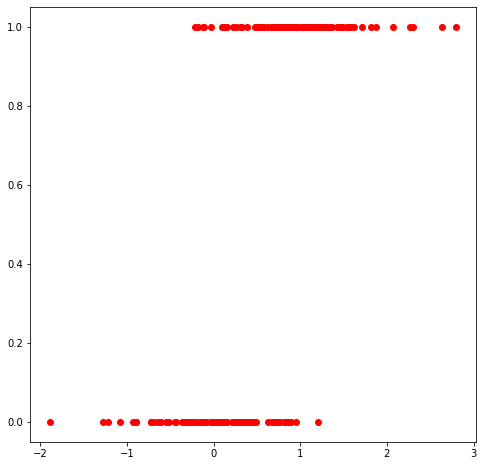

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

cmap = 'coolwarm'
x_r = np.linspace(-2, 2, 100).reshape(-1, 1)

# Original data
ax.scatter(X[:, 1], Y, cmap=cmap, c='red')

for degree in [1, 5, 10]:
    linear_clf = LinearRegression()
    X_aux = poly_basis(base_X, degree=degree)
    linear_clf.fit(X_aux, Y)
    X_aux = poly_basis(x_r, degree=degree)
    y_hat = linear_clf.predict(X_aux)
    ax.plot(x_r, y_hat, label=f"Degree {degree}")
ax.set_xlim(-2, 2)
ax.set_ylim(-1.5, 1.5)
ax.set_title(f"Fitting a degree {orig_degree} polynomial with different degrees")
ax.legend();